# EEG Example (Parcel Level)

Start-to-end example script for applying the canonical HMM to EEG data. Note, because we source reconstruct, we need medium/high-density EEG: ~64+ channels.

In this example, we will use a standard brain in the source reconstruction, so only the EEG data is required.

#### Input Data

We will use data in BIDS format:
```
BIDS/
├── ...
├── sub-04/
│   ├── eeg/
│   │   ├── 01_rest_eyecolsed_raw.fif
│   │   ├── ...
├── ...
```
And write output to the `BIDS/derivatives` directory.

#### Steps

1. Preprocessing:
    - We clean the sensor-level EEG data and save the output to `BIDS/derivatives/preprocessed`.

2. Surface Extraction:
    - We use surfaces from a standard brain (MNI152) extracted with FSL.

3. Coregistration:
    - We will coregister the EEG electrodes with the structural MRI using Polhemus headshape points/fiducials and the surfaces from the MRI.
    - We will also compute the forward model.

4. Source Reconstruction (LCMV Beamformer):
    - We will compute a volumetric LCMV beamformer and apply it to the cleaned sensor data to get data in a voxel grid.

5. Parcellation:
    - We will parcel the data and orthogonalise to remove spatial leakage.
    - The output of steps 2-5 will be saved to `BIDS/derivatives/osl`.

6. Prepare Data for the Canonical HMM:
    - We will perform dipole sign flipping, time-delay embedding, PCA and standardisation to prepare the parcel data for the canonical HMM.

6. Prepare Data for the Canonical HMM:
    - We will perform dipole sign flipping, time-delay embedding, PCA and standardisation to prepare the parcel data for the canonical HMM.

7. Fit the Canonical HMM:
    - We will apply the canonical HMM to the prepared data.

8. HMM Post-Hoc Analysis:
    - Estimate state-specific quantities of interest, such as spectral properties, networks, and summary statistics for dynamics.
    - The output will be saved to `BIDS/derivatives/hmm`.

After Step 5, if your data includes multiple subjects ($N > 2$), Sign Flipping needs to be performed to eliminate the sign ambiguity introduced by source reconstruction and PCA. This process selects a template subject based on the TDE covariance matrices and uses a random search algorithm to align the signs of all other subjects' time series to that template (Note: this tutorial only uses a single subject, so this code is omitted).

 Although we provide a single start-to-end example script, it is possible to separate the different steps. E.g. you may wish to do all the preprocessing (for different sessions) in a script then have a separate script for the coregistration, source reconstruction and parcellation, as well as a different script for the HMM.

To use this script, please place `extra_preproc.py` and `eeg_icaLabel.ipynb` in the root directory.

#### Import Packages

In [1]:
import os
import numpy as np
from scipy import io
from pathlib import Path
from modules import preproc,rhino, source_recon, parcellation, hmm, utils
from osl_dynamics import inference, analysis
from osl_dynamics.utils import plotting
from osl_dynamics.data import Data
import mne
import extra_preproc # new function for preprocessing
mne.viz.set_3d_backend("notebook")
%matplotlib inline

2025-12-05 19:25:01.007307: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using notebook 3d backend.


#### Session Info

Let's specify which session in the `BIDS` directory we wish to study.

We will use the session `01_rest_eyecolsed_raw.fif` for this example.

In [2]:
subject_id = "01_rest_eyecolsed"
session_id = "sub-01"

For EEG data, we need to add the sensor location information to the mne Raw object (needed for source reconstruction). There's no standardised way people save this information and you will likely need to write your own custom function specific to your dataset to add this information.

Note, if you do not have sensor locations, you could use a [standard montage](https://mne.tools/stable/auto_tutorials/intro/40_sensor_locations.html#sphx-glr-auto-tutorials-intro-40-sensor-locations-py).

## 1. Preprocessing

Now, we can clean the sensor data. We will use MNE to do this. Let's load the raw fif file.

In [3]:
raw = mne.io.read_raw_fif(f"BIDS/{session_id}/eeg/{subject_id}_raw.fif", preload=True)

Opening raw data file BIDS/sub-01/eeg/01_rest_eyecolsed_raw.fif...
    Range : 2000 ... 355480 =      2.000 ...   355.480 secs
Ready.
Reading 0 ... 353480  =      0.000 ...   353.480 secs...


Now, let's perform some minimal preprocessing: filtering, downsampling and bad segment detection.

In [4]:
raw = raw.filter(l_freq=1, h_freq=100, method="iir", iir_params={"order": 5, "ftype": "butter"})
raw = raw.resample(sfreq=250)
raw = preproc.detect_bad_segments(raw, picks="eeg", significance_level=0.1)
raw = preproc.detect_bad_segments(raw, picks="eeg", mode="diff", significance_level=0.1)
raw = preproc.detect_bad_segments(raw, picks="eeg", metric="kurtosis", significance_level=0.1)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB


Bad segment detection
---------------------
Modality: eeg
Mode: None
Metric: std
Significance level: 0.1
Maximum fraction: 0.1
Found 0 bad segments: 0.0/353.5 seconds rejected (0.0%)

Bad segment detection
---------------------
Modality: eeg
Mode: diff
Metric: std
Significance level: 0.1
Maximum fraction: 0.1
Found 0 bad segments: 0.0/353.5 seconds rejected (0.0%)

Bad segment detection
---------------------
Modality: eeg
Mode: None
Metric: kurtosis
Significance level: 0.1
Maximum fraction: 0.1
Found 2 bad segments: 4.0/353.5 seconds rejected (1.1%)


Then, we use [ICLabel](https://mne.tools/mne-icalabel/stable/index.html) to identify abnormal components in the EEG data, classifying components with a high confidence score as abnormal and subsequently removing them.


ICA Automatic Artifact Removal (Method: iclabel)
----------------------------
Filtering data copy (1-100Hz) for ICA fitting...
Applying average reference (ICLabel requirement)...
Fitting ICA (method='infomax', n_components=30, picks=eeg)...
Fitting ICA to data using 62 channels (please be patient, this may take a while)
Omitting 1000 of 88370 (1.13%) samples, retaining 87370 (98.87%) samples.
Selecting by number: 30 components
Computing Extended Infomax ICA
Fitting ICA took 25.3s.
Labeling components using iclabel...
Filtering artifact components (threshold > 0.60)...
  ICA007: eye blink (confidence: 0.99) -> [Marked for removal]
  ICA012: eye blink (confidence: 0.97) -> [Marked for removal]
  ICA017: muscle artifact (confidence: 0.48) -> [Kept] (Confidence below threshold)
  ICA018: eye blink (confidence: 0.42) -> [Kept] (Confidence below threshold)
  ICA020: muscle artifact (confidence: 0.32) -> [Kept] (Confidence below threshold)
  ICA021: muscle artifact (confidence: 0.85) -> [Mar

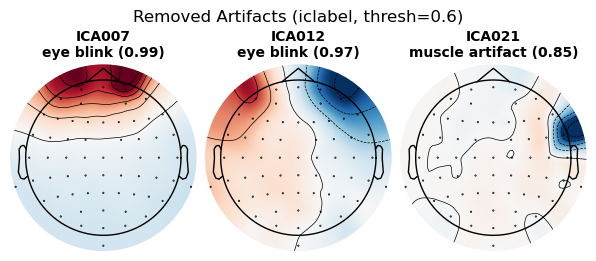

Applying ICA cleaning to original data...
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 62 PCA components


In [5]:
raw = extra_preproc.ica_ICLabel(raw, picks="eeg",n_components=30,threshold=0.6)

Finally, we apply an average re-referencing (needed for source reconstruction) and we save the preprocessed data.

In [6]:
# raw = raw.drop_channels(["VEOG"]) # if you have VEOG channel
raw = raw.set_eeg_reference(projection=True)

preproc_file = Path(f"BIDS/derivatives/preprocessed/{session_id}/{subject_id}_preproc-raw.fif")
preproc_file.parent.mkdir(parents=True, exist_ok=True)
raw.save(preproc_file, overwrite=True)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Overwriting existing file.
Writing /root/Canonical-HMM-Networks/BIDS/derivatives/preprocessed/sub-01/01_rest_eyecolsed_preproc-raw.fif
Overwriting existing file.
Closing /root/Canonical-HMM-Networks/BIDS/derivatives/preprocessed/sub-01/01_rest_eyecolsed_preproc-raw.fif
[done]


[PosixPath('/root/Canonical-HMM-Networks/BIDS/derivatives/preprocessed/sub-01/01_rest_eyecolsed_preproc-raw.fif')]

## 2. Surface Extraction

We need to extract surfaces (inskull, outskull and outskin) from a structural MRI before we can perform the coregistration. In this example we will use a standard brain. However, if you do have a structural you can extract the surfaces with:
```
rhino.extract_surfaces(
    smri_file=smri_file,
    outdir=f"BIDS/derivatives/anat_surfaces/sub-{subject}",
)
```

## OSL Output Files

Now we have the preprocessed sensor data and the MRI surfaces. We can perform an 'OSL' source reconstruction. This involves creating many files. Let's create an object (container) to keep track of all the files.

In [7]:
fns = utils.OSLFilenames(
    outdir=f"BIDS/derivatives/osl/{session_id}",
    id=subject_id,
    preproc_file=f"BIDS/derivatives/preprocessed/{session_id}/{subject_id}_preproc-raw.fif",
    surfaces_dir="mni152_surfaces",  # replace with the 'outdir' used in rhino.extract_surfaces if you have your own structural
)
print(fns)

OSLFilenames for 01_rest_eyecolsed:
  Output directory:  BIDS/derivatives/osl/sub-01
  Preprocessed file: BIDS/derivatives/preprocessed/sub-01/01_rest_eyecolsed_preproc-raw.fif
  Surfaces directory: mni152_surfaces
  BEM directory:     BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/bem
  Coreg directory:   BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/coreg
    └─ Forward model: BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/coreg/model-fwd.fif
  Source directory:  BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/src
    └─ lcmv filters:  BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/src/filters-lcmv.h5


You can adjust the headshape, nasion, LPA, and RPA coordinates here to match head model and fiducial files.

In [8]:
def fix_headshape_fiducials(coreg_dir):
    """
    Directly modifies the headshape and fiducial files in the specified coreg directory.
    
    Parameters:
    coreg_dir: str, The path to the folder containing the Polhemus files.
               Example: 'eeg_data/osl/01_rest_eyecolsed/coreg'
    """
    # 1. Manually construct file paths (assuming default OSL generated filenames)
    # Based on the logs in eeg.ipynb, the standard filenames are as follows:
    filenames = {
        "polhemus_headshape_file": os.path.join(coreg_dir, "polhemus_headshape.txt"),
        "polhemus_nasion_file":    os.path.join(coreg_dir, "polhemus_nasion.txt"),
        "polhemus_lpa_file":       os.path.join(coreg_dir, "polhemus_lpa.txt"),
        "polhemus_rpa_file":       os.path.join(coreg_dir, "polhemus_rpa.txt"),
    }

    # Check if files exist to avoid errors
    for key, fpath in filenames.items():
        if not os.path.exists(fpath):
            raise FileNotFoundError(f"File not found: {fpath}. Please check the path.")

    # 2. Load the saved headshape and fiducial files
    hs = np.loadtxt(filenames["polhemus_headshape_file"])
    nas = np.loadtxt(filenames["polhemus_nasion_file"])
    lpa = np.loadtxt(filenames["polhemus_lpa_file"])
    rpa = np.loadtxt(filenames["polhemus_rpa_file"])
    
    # 3. Modify coordinates (Move fiducials)
    # Scale the headshape
    hs *= 1.3
    # Move along Z-axis (units: mm)
    nas[2] -= 70
    lpa[2] -= 60
    rpa[2] -= 60
    # Move along Y-axis (units: mm)
    nas[1] += 5
    lpa[1] -= 20
    rpa[1] -= 20
    # Move along X-axis (units: mm)
    nas[0] += 0 
    lpa[0] += 0
    rpa[0] -= 0
    
    # 4. Overwrite and save files
    print(f"Updating files in: {coreg_dir}")
    np.savetxt(filenames["polhemus_nasion_file"], nas)
    np.savetxt(filenames["polhemus_lpa_file"], lpa)
    np.savetxt(filenames["polhemus_rpa_file"], rpa)
    np.savetxt(filenames["polhemus_headshape_file"], hs)
    print("Done.")

In [9]:
target_coreg_path = f"BIDS/derivatives/osl/{session_id}/{subject_id}/coreg"

In [10]:
rhino.extract_polhemus_from_fif(fns, include_eeg_as_headshape=True)
fix_headshape_fiducials(target_coreg_path)


Extracting polhemus from fif info
---------------------------------
    Read a total of 1 projection items:
        Average EEG reference (1 x 62)  idle
Saved: BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/coreg/polhemus_nasion.txt
Saved: BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/coreg/polhemus_rpa.txt
Saved: BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/coreg/polhemus_lpa.txt
Saved: BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/coreg/polhemus_headshape.txt
Updating files in: BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/coreg
Done.


There are some files which we have already generated like the preprocessed fif file and the surfaces. Other files we will create in the following steps.

Now let's extract the Polhemus from the preprocessed fif file and coregister the MEG and MRI.

## 3. Coregistration

Next we use the Polhemus headshape points/fiducials to coregister the MEG and structural MRI.


Running coregistration
----------------------
    Read a total of 1 projection items:
        Average EEG reference (1 x 62)  idle
Creating RawArray with float64 data, n_channels=62, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.
Overwriting existing file.
Writing /root/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/coreg/info-raw.fif
Overwriting existing file.
Closing /root/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/coreg/info-raw.fif
[done]
Loading: BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/coreg/polhemus_headshape.txt
Loading: BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/coreg/polhemus_nasion.txt
Loading: BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/coreg/polhemus_rpa.txt
Loading: BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/coreg/polhemus_lpa.txt
Using known MNI-derived fiducials
Running ICP...
ICP found better xform, error=12.010925220616626
Overwriting existing file.
Overwriting existing file.
Overwriti

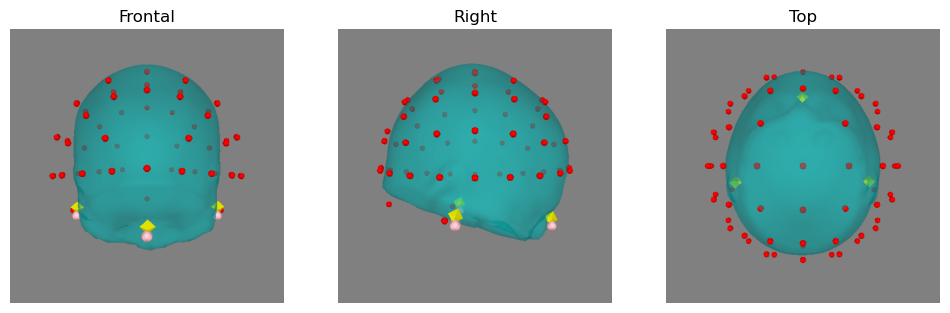

In [11]:
rhino.coregister(
    fns,
    allow_smri_scaling=True,  # set to False if using a real structural
)

Here, because we're using a standard brain, the EEG locations don't perfectly match the scalp. However, because we have real sensor locations, we'll leave them where they are.

Next, we calculate the forward model for MEG. Here, we're using a 'Triple Layer' head model and a dipole grid resolution of 8mm.

In [12]:
rhino.forward_model(fns, model="Triple Layer", gridstep=8, meg=False, eeg=True)


Calculating forward model
-------------------------
Overwriting existing file.
Using bet_inskull_surf_file for single shell surface
Overwriting existing file.
Overwriting existing file.
Surface CM = (   0.5  -20.4    6.1) mm
Surface fits inside a sphere with radius   96.0 mm
Surface extent:
    x =  -71.8 ...   73.6 mm
    y = -108.4 ...   74.5 mm
    z =  -72.8 ...   86.8 mm
Grid extent:
    x =  -72.0 ...   80.0 mm
    y = -112.0 ...   80.0 mm
    z =  -80.0 ...   88.0 mm
11000 sources before omitting any.
6892 sources after omitting infeasible sources not within 0.0 - 96.0 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    4.0 mm away (will take a few...)
Checking surface interior status for 6892 points...
    Found  896/6892 points inside  an interior sphere of radius   47.9 mm
    Found    0/6892 points outside an exterior sphere of radius   96.0 mm
    Found 2721/5996 points outside using surface Qhull
    Found  256/3275 p

## 4. Source Reconstruction

Now we are ready to create an LCMV beamformer. We will use a unit-noise-gain-invariant beamformer.

In [13]:
source_recon.lcmv_beamformer(fns, raw, chantypes="eeg", rank={"eeg": 50})


Making LCMV beamformer
----------------------
Reading forward solution from /root/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/coreg/model-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (3439 sources, 62 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Using up to 1767 segments
Number of samples used : 87350
[done]
Variance for chantype eeg is 4.821185421809226e-11
Computing rank from covariance with rank={'eeg': 50}
Computing rank from covariance with rank='info'
    EEG: rank 61 after 1 projector applied to 62 channels
Making LCMV beamformer with data cov rank {'eeg': 50}
Making LCMV beamformer with noise cov rank {'eeg': 61}
Computing inverse operator with 62 channels.
    62 out of 62 channels remain after picking
Selected 62 channels
Whitening the forward solutio

Next, we calculate voxel data by applying the beamformer weights to the sensor data. Note, the following function returns the voxel data  (and coordinates) in MNI space.

In [14]:
voxel_data, voxel_coords = source_recon.apply_lcmv_beamformer(fns, raw)


Applying LCMV beamformer
------------------------


Omitting 1000 of 88370 (1.13%) samples, retaining 87370 (98.87%) samples.
Reading forward solution from /root/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/coreg/model-fwd.fif...
    Reading a source space...
    [done]
    1 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (3439 sources, 62 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
spatial_resolution = 8 mm
mask_file: BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/src/MNI152_T1_8mm_brain.nii.gz
Finding nearest neighbour in resampled MNI space


## 5. Parcellation

Now we have the voxel data, we can parcellate.

In [15]:
parcellation_file = "fmri_d100_parcellation_with_PCC_reduced_2mm_ss5mm_ds8mm.nii.gz"

parcel_data = parcellation.parcellate(
    fns,
    voxel_data,
    voxel_coords,
    method="spatial_basis",
    orthogonalisation="symmetric",
    parcellation_file=parcellation_file,
)

parc_fif = f"BIDS/derivatives/osl/{session_id}/{subject_id}/lcmv-parc-raw.fif"
parcellation.save_as_fif(
    parcel_data,
    raw,
    extra_chans="stim",
    filename=parc_fif,
)


Parcellating data
-----------------
gridstep = 8 mm
Resampled parcellation: BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/src/fmri_d100_parcellation_with_PCC_reduced_2mm_ss5mm_ds8mm_8mm.nii.gz
Finding nearest neighbour voxel


Calculating parcel time courses with spatial_basis
Performing symmetric orthogonalisation
Saving BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/lcmv-parc-raw.fif
Omitting 1000 of 88370 (1.13%) samples, retaining 87370 (98.87%) samples.
Creating RawArray with float64 data, n_channels=38, n_times=88370
    Range : 0 ... 88369 =      0.000 ...   353.476 secs
Ready.
No stim channel to add to parc-raw.fif
Overwriting existing file.
Writing /root/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/lcmv-parc-raw.fif
Overwriting existing file.
Closing /root/Canonical-HMM-Networks/BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/lcmv-parc-raw.fif
[done]


/root/Canonical-HMM-Networks/modules/parcellation.py:639: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  parc_raw.set_annotations(raw._annotations)


The final data is saved in the file `lcmv-parc-raw.fif`. The parcellated data is saves as a `'misc'` channel type.

The last thing we will do is plot the PSD of the parcel data to check the source reconstruction looks reasonable.

Opening raw data file BIDS/derivatives/osl/sub-01/01_rest_eyecolsed/lcmv-parc-raw.fif...
Isotrak not found
    Range : 500 ... 88869 =      2.000 ...   355.476 secs
Ready.
Omitting 1000 of 88370 (1.13%) samples, retaining 87370 (98.87%) samples.


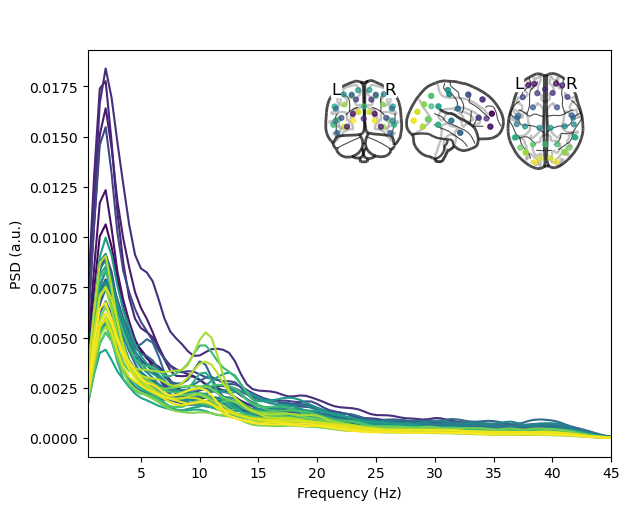

In [16]:
parcellation.plot_psds(parc_fif, parcellation_file=parcellation_file)

We should see alpha (~10 Hz) activity is posterior in the brain if not there may be an issue. Although note, there is a lot of subject variability, some subjects don't exhibit strong alpha oscillations.

## 6. Prepare Data for the Canonical HMM

Here, we prepare the data by aligning the sign of the parcel time courses to the template session from the canonical HMM and then perform time-delay embedding and PCA. Finally, we standardise the data. This is all done with the `prepare_data_for_canonical_hmm` function.

In [17]:
# Load and prepare the data
data = Data(parc_fif, picks="misc", reject_by_annotation="omit")
data = hmm.prepare_data_for_canonical_hmm(data, parcellation="38ROI_Giles")

# Save
hmm_dir = f"BIDS/derivatives/hmm/{session_id}/{subject_id}"
data.save(hmm_dir)

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating covariances:   0%|          | 0/1 [00:00<?, ?it/s]

2025-12-05 19:27:35 INFO osl-dynamics [base.py:1172:align_channel_signs]: Aligning channel signs across sessions
2025-12-05 19:27:47 INFO osl-dynamics [base.py:1135:_find_and_apply_flips]: Session 0, Init 0, best correlation with template: 0.128
2025-12-05 19:27:59 INFO osl-dynamics [base.py:1135:_find_and_apply_flips]: Session 0, Init 1, best correlation with template: 0.131
2025-12-05 19:28:10 INFO osl-dynamics [base.py:1135:_find_and_apply_flips]: Session 0, Init 2, best correlation with template: 0.135


TDE-PCA:   0%|          | 0/1 [00:00<?, ?it/s]

Standardize:   0%|          | 0/1 [00:00<?, ?it/s]

Saving data:   0%|          | 0/1 [00:00<?, ?it/s]

## 7. Fit the Canonical HMM

First, we load a canonical HMM.

In [18]:
model = hmm.load_canonical_hmm(n_states=8, parcellation="38ROI_Giles")
model.summary()

I0000 00:00:1764934091.687319  316604 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1764934091.985338  316604 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x65481e4f6630


Model: "HMM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 400, 80)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ means               │ (8, 80)           │        640 │ data[0][0]        │
│ (VectorsLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ covs                │ (8, 80, 80)       │     25,920 │ data[0][0]        │
│ (CovarianceMatrice… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll                  │ (None, 400, 80)   │          0 │ data[0][0],       │
│ (SeparateLogLikeli… │                   │            │ means[0][0],      │
│                     │                   │            │ covs[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hid_state_inf       │ [(None, 400, 80), │         72 │ ll[0][0]          │
│ (HiddenMarkovState… │ (None, 400, 8,    │            │                   │
│                     │ 8)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll_loss             │ (1)               │          0 │ ll[0][0],         │
│ (SumLogLikelihoodL… │                   │            │ hid_state_inf[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,632 (104.03 KB)

 Trainable params: 25,992 (101.53 KB)

 Non-trainable params: 640 (2.50 KB)

Now let's infer the probability of each state being active at a given time point in the new data.

2025-12-05 19:28:13 INFO osl-dynamics [inf_mod_base.py:1141:get_alpha]: Getting alpha
2025-12-05 19:28:15.953569: I external/local_xla/xla/service/service.cc:163] XLA service 0x77212c024930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-05 19:28:15.953613: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-12-05 19:28:16.072558: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-05 19:28:16.462890: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-12-05 19:28:16.538389: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of val

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Overwriting existing file.
Writing /root/Canonical-HMM-Networks/BIDS/derivatives/hmm/sub-01/01_rest_eyecolsed/alp_raw.fif
Overwriting existing file.
Closing /root/Canonical-HMM-Networks/BIDS/derivatives/hmm/sub-01/01_rest_eyecolsed/alp_raw.fif
[done]


2025-12-05 19:28:24.520501: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/root/miniconda3/envs/osld/lib/python3.12/site-packages/osl_dynamics/inference/modes.py:601: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  alpha_raw.set_annotations(raw._annotations)


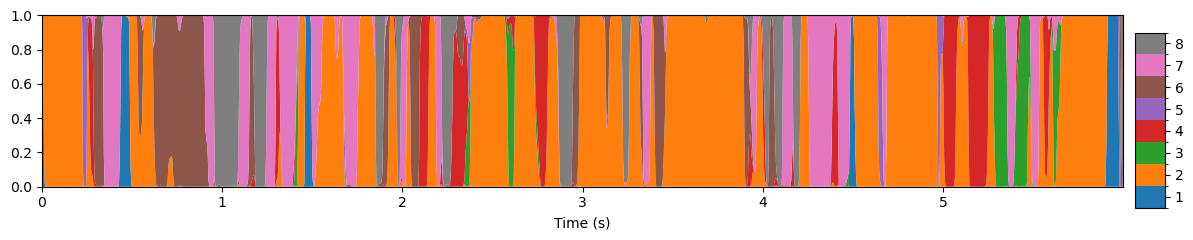

In [19]:
# State probability time course
alp = model.get_alpha(data)

# Save
alp_raw = inference.modes.convert_to_mne_raw(alp, parc_fif, n_embeddings=data.n_embeddings)
alp_raw.save(f"{hmm_dir}/alp_raw.fif", overwrite=True)

# Plot (just the first 8 seconds for visualisation)
fig, ax = plotting.plot_alpha(alp, n_samples=1500, sampling_frequency=alp_raw.info["sfreq"])

## 8. HMM Post-Hoc Analysis

Now we have the state probabilities, we can perform 'post-hoc analysis' where we estimate state-specific quantities of interest such as spectral properties, networks, and summary statistics for dynamics.

See the [osl-dynamics docs](https://osl-dynamics.readthedocs.io/en/latest/documentation.html) for further information and tutorials, as well as code for visualisations.

Let's start with the spectral properties.

In [20]:
# Calculate multitaper
trimmed_data = data.trim_time_series(sequence_length=model.config.sequence_length, prepared=False)
f, psd, coh = analysis.spectral.multitaper_spectra(
    data=trimmed_data,
    alpha=alp,
    sampling_frequency=250,
    frequency_range=[0.5, 45],
)
print(f.shape)
print(psd.shape)
print(coh.shape)

# Save
np.save(f"{hmm_dir}/f.npy", f)
np.save(f"{hmm_dir}/psd.npy", psd)
np.save(f"{hmm_dir}/coh.npy", coh)

2025-12-05 19:28:24 INFO osl-dynamics [spectral.py:458:multitaper_spectra]: Calculating spectra


(90,)
(8, 38, 90)
(8, 38, 38, 90)


Now let's use the spectra to calculate state-specific networks.

In [21]:
# Power maps
pow_maps = analysis.power.variance_from_spectra(f, psd)
print(pow_maps.shape)
np.save(f"{hmm_dir}/pow_maps.npy", pow_maps)

# Coherence networks
coh_nets = analysis.connectivity.mean_coherence_from_spectra(f, coh)
print(coh_nets.shape)
np.save(f"{hmm_dir}/coh_nets.npy", coh_nets)

(8, 38)
(8, 38, 38)


Finally, let's calculate summary statistics for dynamics.

In [22]:
# Binarise the state probabilities
stc = inference.modes.argmax_time_courses(alp)

# Summary statistics
fo = analysis.post_hoc.fractional_occupancies(stc)
lt = analysis.post_hoc.mean_lifetimes(stc, sampling_frequency=raw.info["sfreq"])
intv = analysis.post_hoc.mean_intervals(stc, sampling_frequency=raw.info["sfreq"])
sr = analysis.post_hoc.switching_rates(stc, sampling_frequency=raw.info["sfreq"])

# Save
np.save(f"{hmm_dir}/fo.npy", fo)
np.save(f"{hmm_dir}/lt.npy", lt)
np.save(f"{hmm_dir}/intv.npy", intv)
np.save(f"{hmm_dir}/sr.npy", sr)